## Employees' 2021 Historical and Predicted Weekly Hours
**Author:** Sarah Chu

This project is to perform data wrangling on both datasets, merge them, and create a PIVOT table and a heatmap to illustrate employees' past and future weekly hours in *percentage*.

## Data Overview
Essential data include:
* **SF.csv:** Dataset extracted from Salesforce with clients' and associated employees' information
* **Utilization.csv:** Dataset extracted from Harvest API with employees' historical hours in percentage

## Project Workflow
1. Import Essential Packages & Load Datasets
2. Preprocess the Loaded Datasets
3. Create Heatmap
4. Export Merged Data (PIVOT) & Heatmap

## 1. Import Essential Packages & Load Datasets

**Importing Packages**

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

**Load Datasets**

Define function to determine whether the entered file names exist.

In [2]:
def find_file(file_name):
    '''Determine whether the file exist in the current directory'''
    files = [f for f in os.listdir('.') if os.path.isfile(f)]
    return file_name in files

Require the user to enter the names of the files

In [3]:
sf_file_name = input('Enter the path to your Salesforce file name:')
harvest_file_name = input('Enter the path to your Harvest file name:')

Enter the path to your Salesforce file name: SF_data.csv
Enter the path to your Harvest file name: Utilization.csv


## 2. Preprocess the Loaded Datasets

**Salesforce Data**
* Select needed variables
* Rename columns
* Date reformat
* Filter needed rows
* Identify which employee has not ended in a project


**Harvest Data**
* Rename columns
* Date reformat
* Add roles

**Preprocessed Data**
* PIVOT table of a merged data (Salesforce & Harvest)

In [4]:
def preprocess(sf_df,harvest_df):
    '''Preprocessed Salesforce and Harvest data that returns a PIVOT table which combines the two datasets'''

    #New Salesforce dataset with the needed columns
    sf_df_new = sf_df[['Account Name', 'Close Date', 'Last Name', 'Department', 'Role Expiration Date', 'Allocation %']]
    #Add a Name column to the original Salesforce dataset for later
    sf_df['Name'] = sf_df['First Name'] + " " +  sf_df['Last Name']
    #Rename the utilization dataset from Harvest
    harvest_df = harvest_df.rename(columns={"user.name":"Name", "date": "Date", "utilization": "Allocation %"})

    def change_date_format(col):
        '''Reformat dates to YYYY-MM-DD'''
        col = pd.to_datetime(col).dt.date
        return col

    #Date reformat in both datasets
    sf_df_new['Close Date'] = change_date_format(sf_df_new['Close Date'])
    sf_df_new['Role Expiration Date'] = change_date_format(sf_df_new['Role Expiration Date'])
    harvest_df['Date'] = change_date_format(harvest_df['Date'])
    
    #Remove % and make it a number if % is found 
    if '%' in list(sf_df_new['Allocation %']):
        sf_df_new['Allocation %'] = list(map(lambda x: x[:-1], sf_df_new['Allocation %'].values))
        sf_df_new['Allocation %'] = [float(x) for x in sf_df_new['Allocation %'].values]


    #Create a dataframe with the each resource's most recent date
    most_recent_df = harvest_df.groupby(['Name'], sort=False)['Date'].max()
    
    #Data filtering: only need allocation % for Role Expiration Dates that haven't expired
    sf_df_new = sf_df_new[sf_df_new['Role Expiration Date'] >= date.today()]

    add_week_list = []
    date_range_list = []

    #For any of the resources whose Role Expiration Date has not ended
    for i in range(len(sf_df_new.index)):
        for j in range(len(most_recent_df.index)):
            if sf_df_new.iloc[i,4] > most_recent_df[j] and sf_df_new.iloc[i,2] in most_recent_df.index[j]:
                roleExp = sf_df_new.iloc[i,4]
                addStartDate = most_recent_df[j]
                addWeeks = (roleExp - addStartDate).days / 7
                
                #If the date doesn't end on a Saturday then add the allocation % to the following Sunday
                if addWeeks % 7 != 0:
                    addWeeks += 2

                add_week_list.append(sf_df_new.iloc[[i]*int(addWeeks)])
    
                date_range_list.append(pd.Series(pd.date_range(addStartDate, periods= addWeeks, freq='7D')))

    date_range_series = pd.concat(date_range_list)

    #Reset index for all the future dates
    date_range_series = date_range_series.reset_index(drop=True)

    add_week_df = pd.concat(add_week_list)
    add_week_df = add_week_df.reset_index(drop=True)
    add_week_df['Role Expiration Date'].update(date_range_series)
    add_week_df['Role Expiration Date'] = change_date_format(add_week_df['Role Expiration Date'])

    def add_role(name, df):
        '''Add role to matching names'''
        sf_name_list = list(df['Name'])
        for i in sf_name_list:
            if name == i:
                name_index = sf_name_list.index(i)
                return sf_df.loc[name_index, 'Department']

    def change_full_name(last_name, names):
        '''Changes last name to full name'''
        for i in names:
            if last_name in i:
                return i
    
    #Additional weeks dataset with the needed columns
    add_week_new_df = add_week_df[['Last Name', 'Department', 'Role Expiration Date', 'Allocation %']]
    add_week_new_df = add_week_new_df.rename(columns={'Last Name': 'Name', 'Department': 'Role', 'Role Expiration Date': 'Date'})

    name_list = list(harvest_df['Name'].unique())
    role_list = list(add_week_new_df['Role'].unique())
    sf_name_list = list(sf_df['Name'])


    #Replace each row of Last Name using Change Full Name
    add_week_new_df['Name'] = add_week_new_df['Name'].apply(lambda x: change_full_name(x, name_list))

    #Add roles to Harvest data
    harvest_df['Role'] = harvest_df['Name'].apply(lambda x: add_role(x, sf_df))

    #Final dataset: Combined the original Harvest data with the preprocessed Salesforce data
    final_df = pd.concat([add_week_new_df, harvest_df], ignore_index=True)
    
    #Pivot table made with the Final dataset
    final_piv = final_df.pivot_table(index=['Name','Role'], columns=['Date'], values=['Allocation %'])
    final_piv = final_piv.rename(columns= {'Allocation %': ''})
    final_piv = final_piv.fillna(0)

    # return final_piv
    return final_piv

In [5]:
#If both input files exist
if find_file(sf_file_name) and find_file(harvest_file_name) is True:
    sf_df = pd.read_csv(sf_file_name)
    harvest_df = pd.read_csv(harvest_file_name)
    preprocessed_df = preprocess(sf_df,harvest_df)
else:
    print('Please enter an existing file name.')

/Users/Chu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Chu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Chu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the w

## 3. Create Heatmap

Create a heatmap using the PIVOT table to illustrate employees' hours with different colors with higher hours with lighter shades and lower hours with darker shades.

In [6]:
def save_heatmap(df):
    '''Graph the heatmap with the preprocessed data through graphic specifications and designs'''
    fig, ax = plt.subplots(figsize=(100,70))
    df = df.round().astype(int)
    sns.set(font_scale=3)
    heat = sns.heatmap(df, annot=True, cmap='viridis', fmt='g',annot_kws={"size":38}, linewidths=1.2, linecolor="grey", vmin=0, vmax=200)
    heat.figure.axes[-1].yaxis.label.set_size(45)
    ax.xaxis.tick_top()
    ax.set_title('Utilization: Historical and Forecast', pad=80, fontsize=80)
    plt.xticks(fontsize=38, rotation=90)
    plt.yticks(fontsize=40, rotation=360)
    ax.set_xticklabels([x[1].date() for x in df.columns])
    ax.set_ylabel('')
    ax.set_xlabel('')
    cb = ax.collections[0].colorbar
    cb.set_label('Allocation(%)',labelpad=100)
    plt.savefig("Weekly Hours:Historical_and_Forecast.jpg")
    plt.show()

## 4. Export Merged Data & Heatmap

Automatically export a csv and jpg in the local directory.

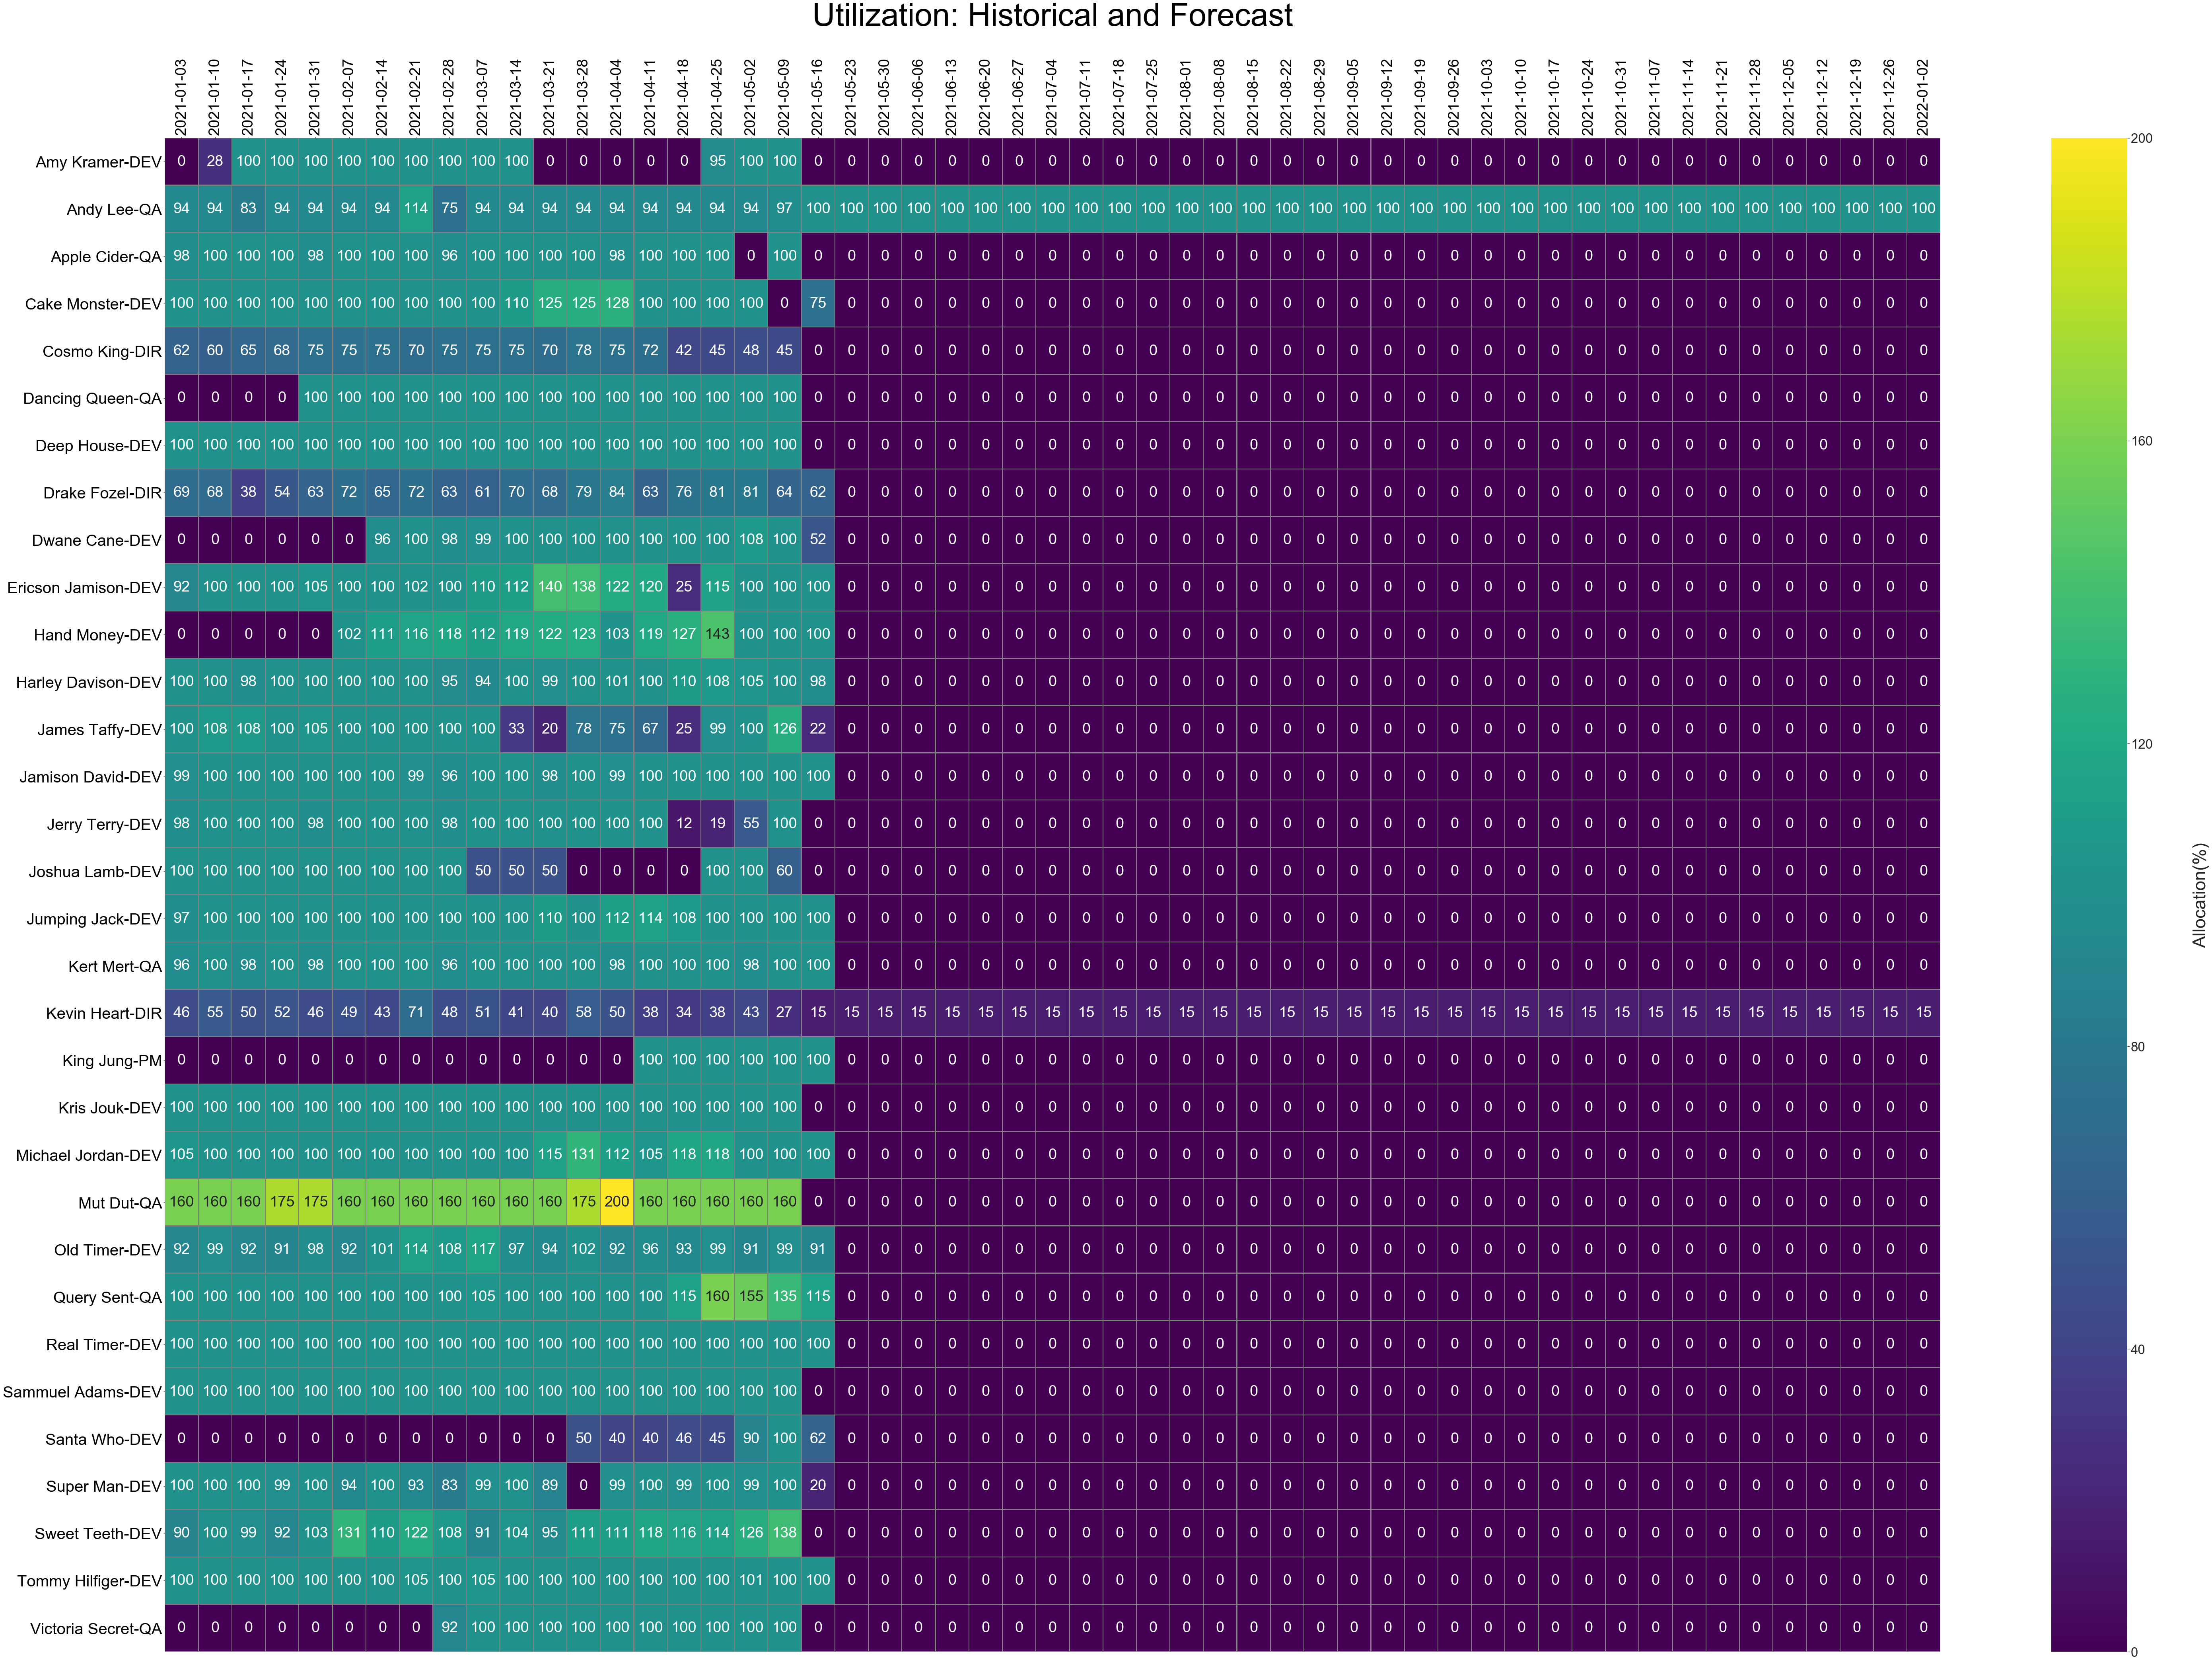

In [7]:

preprocessed_df.to_csv('utilization_historical_and_forecast.csv')

#Save heatmap
save_heatmap(preprocessed_df)